In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import os
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import sklearn.metrics as metrics

plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor




Create Stock class to hold stock data

In [55]:
#create a date parser
dateParser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

class Stock:
    def __init__(self, name, filename):
        self.name = name
        self.data = pd.read_csv(filename, sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateParser).fillna(0)
        self.df_log = np.log(self.data.Close)
        self.train_data, self.test_data = self.df_log[3:int(len(self.df_log)*0.9)], self.df_log[int(len(self.df_log)*0.9):]

    def getName(self):
        return self.name
    
    def getData(self):
        return self.data

    def getDf_log(self):
        return self.df_log

    def getTrain(self):
        return self.train_data
    
    def getTest(self):
        return self.test_data

Initialize Stock Data Objects

In [56]:
apple = Stock("Apple: AAPL", "aapl.us.txt")
google = Stock("Google: GOOGL", "googl.us.txt")
amazon = Stock("Amazon: AMZN", "amzn.us.txt")
alibaba = Stock("Alibaba: BABA", "baba.us.txt")
berkshireHathaway = Stock("Berkshire Hathaway: BRK A", "brk-a.us.txt")
facebook = Stock("Facebook: FB", "fb.us.txt")
jpmorgan = Stock("JPMorgan: JPM", "jpm.us.txt")
microsoft = Stock("Microsoft: MCFT", "mcft.us.txt")
tesla = Stock("Tesla: TSLA", "tsla.us.txt")
visa = Stock("Visa: V", "v.us.txt")

stocklist = [apple]


<ipython-input-55-f583731fb4df>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateParser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


Plot of CLosing Prices

In [57]:
def plotClosingPrice(data, name):
        plt.figure(figsize=(10,6))
        plt.grid(True)
        plt.xlabel('Date')
        plt.ylabel('Close Prices')
        plt.plot(data['Close'])
        plt.title(name + '  Closing Price')
        plt.show()

Test plotclosingprice

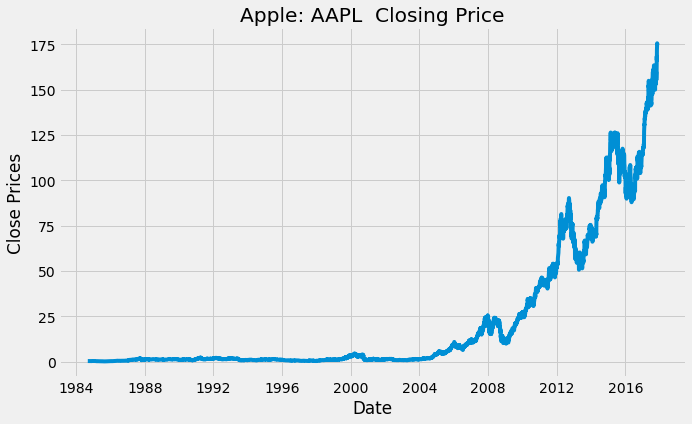

In [58]:
for stock in stocklist:
    plotClosingPrice(stock.getData(), stock.getName())

Kernel Density Function

In [59]:
def plotKernalDensityEstimate(data, name):
        data.Close.plot(kind='kde')
        plt.title(name + "  Kernal Density Estimate")
        plt.show() #this line can be taken out to show all the plots against each other 

The below graph is a kernal density estimate plot. This is analagous to a histogram and represents the data using a continuous probability density curve.

Test Kernal Density Function

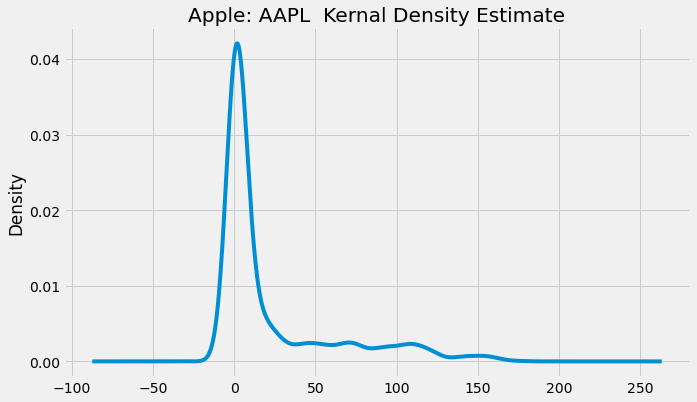

In [60]:

for stock in stocklist:
    plotKernalDensityEstimate(stock.getData(), stock.getName())

<hr/>
Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

    Level: The average value in the series.

    Trend: The increasing or decreasing value in the series.

    Seasonality: The repeating short-term cycle in the series.

    Noise: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


<h3 style="color: skyblue; padding-top: 10px; text-decoration: underline;">ADF (Augmented Dickey-Fuller) Test</h3></red>

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

So let's check for stationarity:

In [61]:
#Test for staionarity
def test_stationarity(timeseries, name):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(name + '  Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

Test stationarity function

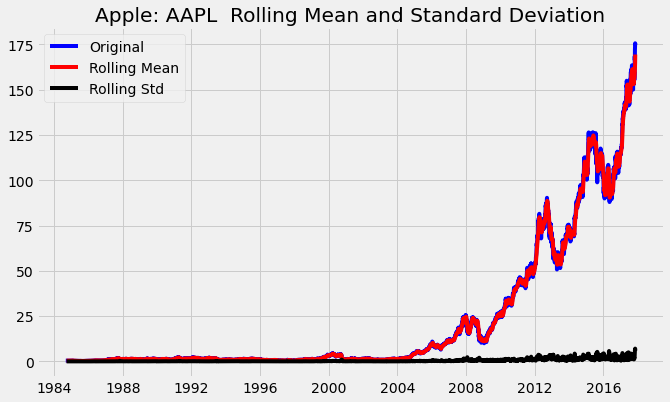

Results of dickey fuller test
Test Statistics                   4.373924
p-value                           1.000000
No. of lags used                 37.000000
Number of observations used    8326.000000
critical value (1%)              -3.431136
critical value (5%)              -2.861887
critical value (10%)             -2.566955
dtype: float64


In [62]:

for stock in stocklist:
    test_stationarity(stock.getData().Close, stock.getName())



Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

In [63]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.

#seperate trend and seasonality by decomposing
def seasonalDecompose(data, name):
    result = seasonal_decompose(data.Close, model='multiplicative', freq = 30)
    fig = plt.figure()
    fig = result.plot()
    fig.suptitle(name, fontsize=20) 
    fig.set_size_inches(16, 9)

Test seasonal decompose

<ipython-input-63-dc22684f16f8>:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(data.Close, model='multiplicative', freq = 30)


<Figure size 720x432 with 0 Axes>

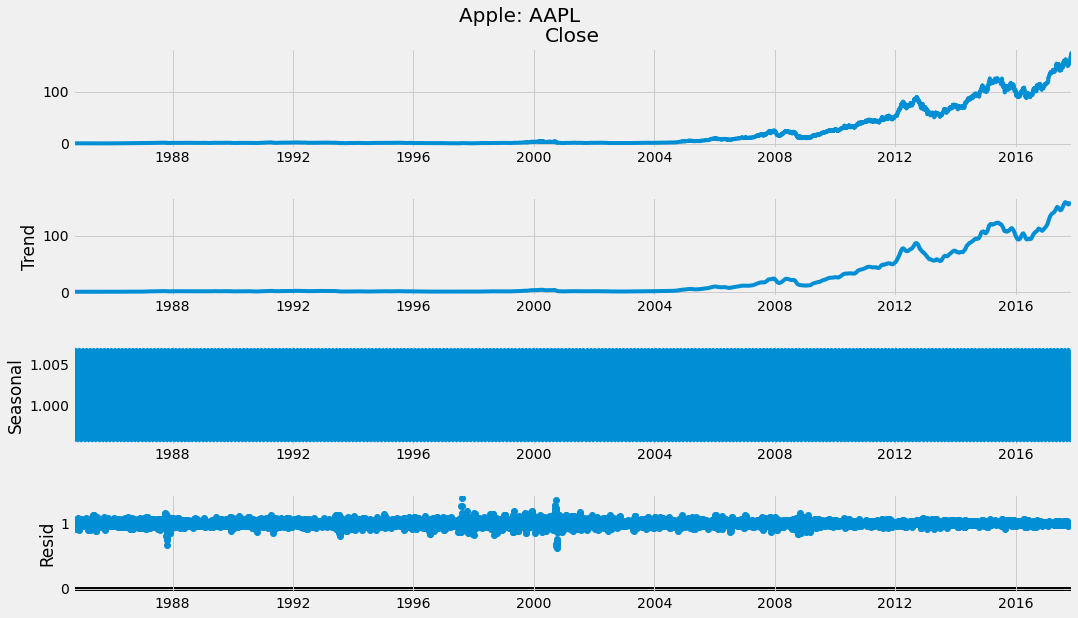

In [64]:

for stock in stocklist:
    seasonalDecompose(stock.getData(), stock.getName())


We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

In [65]:
#if not stationary then eliminate trend
#eliminate trend
def movingAverage(data, name):
    df_log = np.log(data.Close)
    moving_avg = df_log.rolling(12).mean()
    std_dev = df_log.rolling(12).std()
    plt.legend(loc='best')
    plt.title(name + ': Moving Average')
    plt.plot(std_dev, color ="black", label = "Standard Deviation")
    plt.plot(moving_avg, color="red", label = "Mean")
    plt.legend()
    plt.show()



test moving average function

No handles with labels found to put in legend.


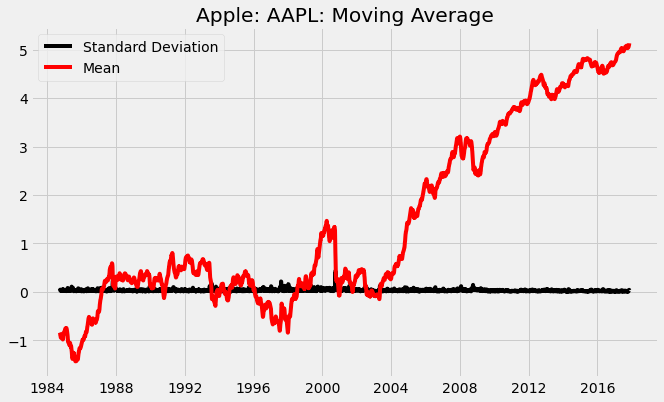

In [66]:

for stock in stocklist:
    movingAverage(stock.getData(), stock.getName())



<h3 style="color: skyblue;">Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.</h3>

In [67]:
def trainTestClosingPrices(data, name):
    df_log = np.log(data.Close)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Logged Closing Prices')
    plt.title(name)
    plt.plot(df_log, 'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()

Test train test closing prices function

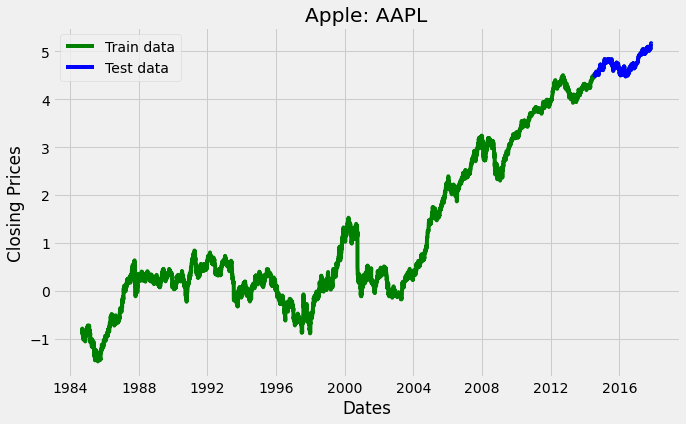

In [68]:

for stock in stocklist:
    trainTestClosingPrices(stock.getData(), stock.getName())


Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

<i>Auto ARIMA: Automatically discover the optimal order for an ARIMA model. The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.</i>

The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [69]:
def autoArima(data, name):
    df_log = np.log(data.Close)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    print("\n\n\n" + name + " Auto ARIMA ")
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=3, max_q=3, # maximum p and q
                    m=1,              # frequency of series
                    d=None,           # let model determine 'd'
                    seasonal=False,   # No Seasonality
                    start_P=0, 
                    D=0, 
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)
    print(model_autoARIMA.summary())
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()

test auto arima




Apple: AAPL Auto ARIMA 
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31377.404, Time=0.91 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31375.594, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31375.597, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31375.178, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-31373.598, Time=1.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.912 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7524
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15690.702
Date:                Sun, 21 Mar 2021   AIC                         -31377.404
Time:                        16:14:42   BIC                         -31363.553
Sample:                             0   HQIC                        -31372.648
                               - 7524  

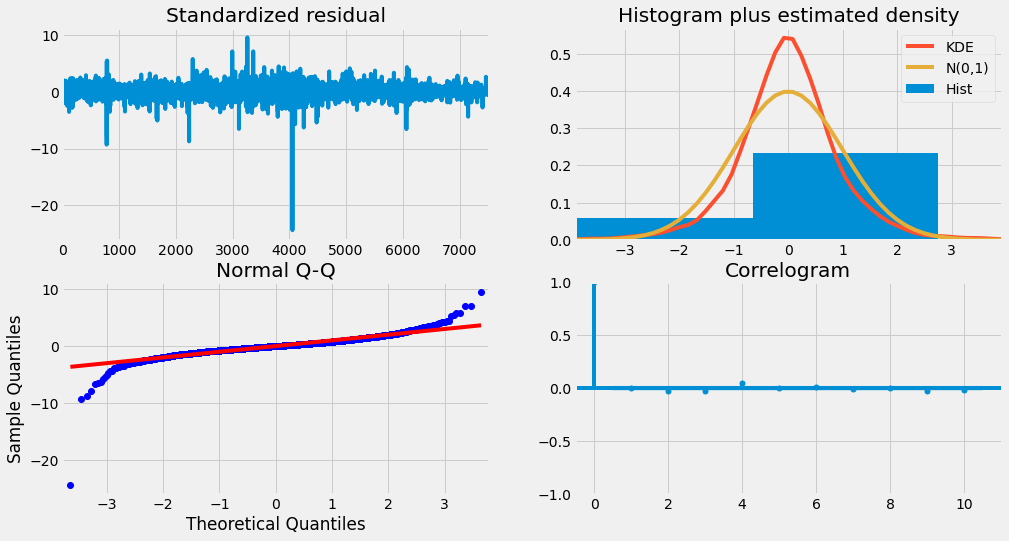

In [70]:

for stock in stocklist:
    autoArima(stock.getData(), stock.getName())


So how to interpret the plot diagnostics?

    Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

    Top Right: The density plot suggest normal distribution with mean zero.

    Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

    Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

Next, create an ARIMA model with provided optimal parameters p, d and q.

In [71]:
# build model
def buildArimaModel(data, name, printmodel):
    df_log = np.log(data.Close)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    model = ARIMA(train_data, order=(1,1,2))  
    fitted = model.fit(disp=-1)  
    if printmodel == True:
        print(fitted.summary())
    return fitted

test build arima model function

In [72]:

for stock in stocklist:
    buildArimaModel(stock.getData(), stock.getName(), True)


C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [73]:
# Forecast
def forecast(data, train_data, test_data, name):
    # df_log = np.log(data.Close)
    # train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    fitted = buildArimaModel(data, name, False)
    fc, se, conf = fitted.forecast(len(test_data.index), alpha=0.05)  # 95% conf
    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf[:, 0], index=test_data.index)
    upper_series = pd.Series(conf[:, 1], index=test_data.index)
    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training data')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                    color='k', alpha=.10)
    plt.title(name + ' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(name + ' Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()


test forecast

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

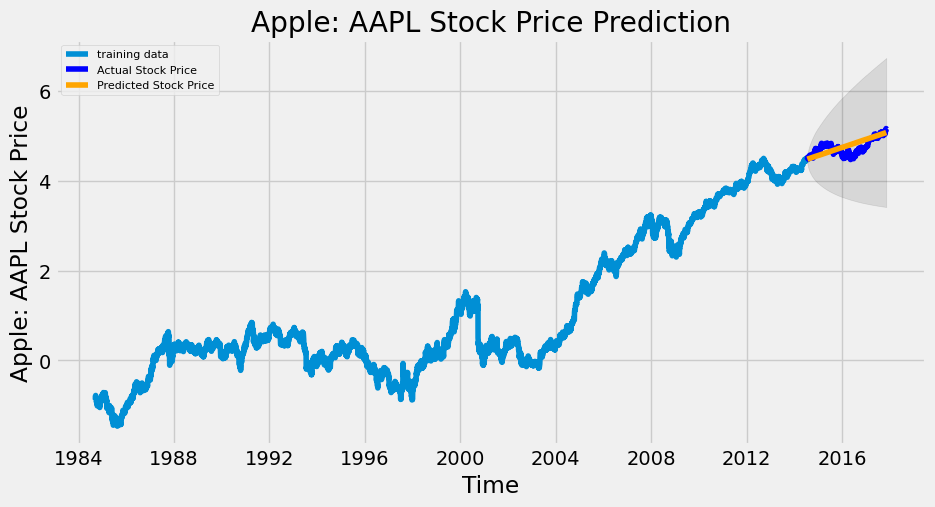

In [74]:

for stock in stocklist:
    forecast(stock.getData(), stock.getTrain(), stock.getTrain(), stock.getName())


Results

Mertics Meaning

    diff_pred: difference between the predicted current point and one before it
    diff_true: difference between true current point and one before it
    sign_pred: positive or negative sign of the difference for prediction
    sign_true: positive or negative sign of the difference for true value
    is_correct: 1 if sign_pred == sign_true, otherwise 0
    is_incorrect: 0 if sign_pred == sign_true, otherwise 1
    is_predicted: 1 if the model has made a valid prediction 0 if not (used for confidence levels)
    result: the loss resulting from the predicted sign applied to the actual value

In [75]:
#make dataframe thats useful for metrics
def makedf(data, name):
    df_log = np.log(data.Close)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    fitted = buildArimaModel(data, name, False)
    fc, se, conf = fitted.forecast(len(test_data.index), alpha=0.05)  # 95% conf
    y_true = pd.DataFrame(pd.Series(fc, index=test_data.index))
    y_pred = pd.DataFrame(test_data)
    
    df = pd.concat([y_pred, y_true],axis=1)
    df.columns = ['y_pred', 'y_true']

    df['diff_pred'] = df.y_pred.diff()
    df['diff_true'] = df.y_true.diff()
    df['sign_pred'] = df.diff_pred.apply(np.sign)
    df['sign_true'] = df.diff_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred *df.sign_true >0, 'is_correct'] = 1
    df['is_incorrect'] = 0
    df.loc[df.sign_pred *df.sign_true <0, 'is_incorrect'] = 1
    df['is_predicted'] = df.is_correct +df.is_incorrect
    df['result'] = df.sign_pred * df.y_true
    return df

#makeDF from ypred, ytrue (for use in compare models function)
def makeDF(yPred, yTrue, name):
    y_true = pd.DataFrame(yTrue)
    y_pred = pd.DataFrame(yPred)
    
    df = pd.concat([y_pred, y_true],axis=1)
    df.columns = ['y_pred', 'y_true']

    df['diff_pred'] = df.y_pred.diff()
    df['diff_true'] = df.y_true.diff()
    df['sign_pred'] = df.diff_pred.apply(np.sign)
    df['sign_true'] = df.diff_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred *df.sign_true >0, 'is_correct'] = 1
    df['is_incorrect'] = 0
    df.loc[df.sign_pred *df.sign_true <0, 'is_incorrect'] = 1
    df['is_predicted'] = df.is_correct +df.is_incorrect
    df['result'] = df.sign_pred * df.y_true
    return df


test makeDF function

calc scores

In [76]:
def calcScores(df):
    scores = pd.Series()
    
    #building block metrics
    scores.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scores.loc['edge'] = df.result.mean()
    scores.loc['noise'] = df.y_pred.diff().abs().mean()
    
    #metrics
    scores.loc['yTrueChange'] = df.y_true.abs().mean()
    scores.loc['yPredChange'] = df.y_pred.abs().mean()
    scores.loc['predictionCalibration'] = scores.loc['yPredChange']/scores.loc['yTrueChange']
    scores.loc['captureRatio'] = scores.loc['edge']/scores.loc['yTrueChange']*100
    
    #subset prediction metrics
    scores.loc['edgeLong'] = df[df.sign_pred == 1].result.mean()-df.y_true.mean()
    scores.loc['edgeShort'] = df[df.sign_pred == -1].result.mean()-df.y_true.mean()
    scores.loc['edgeWin'] = df[df.is_correct ==1].result.mean() - df.y_true.mean()
    scores.loc['edgeLose'] = df[df.is_incorrect ==1].result.mean() - df.y_true.mean()
    
    return scores

test calc scores function

scores by year

In [77]:
def scoresByYear(df):
        df['year'] = df.index.get_level_values('Date').year
        return df.groupby('year').apply(calcScores).T


test scores by year function


In [78]:


for stock in stocklist:
    stockDF = makedf(stock.getData(), stock.getName())
    print(stockDF.dropna().tail())
    print(calcScores(stockDF))
    print(scoresByYear(stockDF))

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
              y_pred    y_true  diff_pred  diff_true  sign_pred  sign_true  \
Date                                                                         
2017-11-06  5.156927  5.077366   0.010130   0.000712        1.0        1.0   
2017-11-07  5.160089  5.078079   0.003163   0.000712        1.0        1.0   
2017-11-08  5.168266  5.078791   0.008176   0.000712        1.0        1.0   
2017-11-09  5.166214  5.079503  -0.00205

comparing different models


In [79]:
#comparing to different models

def compareModels(data, train_data, test_data, name):
    fitted = buildArimaModel(data, name, False)
    fc, se, conf = fitted.forecast(len(test_data.index), alpha=0.05)  # 95% conf
    fc_series = pd.Series(fc, index=test_data.index)
    #preprocess and split data
    xTrain = np.array(train_data.index.map(datetime.datetime.toordinal)).reshape(-1,1)
    xTest = np.array(test_data.index.map(datetime.datetime.toordinal)).reshape(-1,1)
    yTrain = train_data.values
    yTest = test_data.values

    #linear regression
    lr = LinearRegression().fit(xTrain,yTrain)
    lr_train = pd.Series(lr.predict(xTrain))
    lr_test = pd.Series(lr.predict(xTest))

    #KNN 
    knn = KNeighborsRegressor(n_neighbors=80, weights='uniform', algorithm='auto', leaf_size=30, p=2).fit(xTrain,yTrain)
    knn_train = pd.Series(knn.predict(xTrain))
    knn_test = pd.Series(knn.predict(xTest))

    #Lasso Regression 
    ls = Lasso(alpha =0.0001, max_iter=200000).fit(xTrain,yTrain)
    ls_train = pd.Series(ls.predict(xTrain))
    ls_test = pd.Series(ls.predict(xTest))

    #Elastic Net
    en = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=20000).fit(xTrain,yTrain)
    en_train = pd.Series(en.predict(xTrain))
    en_test = pd.Series(en.predict(xTest))

    #Ridge Regression
    rr = Ridge(alpha=1).fit(xTrain,yTrain)
    rr_train = pd.Series(rr.predict(xTrain))
    rr_test = pd.Series(rr.predict(xTest))

    #Random Forest Regressor
    rf = RandomForestRegressor().fit(xTrain,yTrain)
    rf_train = pd.Series(rf.predict(xTrain))
    rf_test = pd.Series(rf.predict(xTest))

    #get data frames
    lr_train_df = makeDF(lr_train, yTrain, name)
    lr_test_df = makeDF(lr_test, yTest, name)

    knn_train_df = makeDF(knn_train, yTrain, name)
    knn_test_df = makeDF(knn_test, yTest, name)

    ls_train_df = makeDF(ls_train, yTrain, name)
    ls_test_df = makeDF(ls_test, yTest, name)

    en_train_df = makeDF(en_train, yTrain, name)
    en_test_df = makeDF(en_test, yTest, name)

    rr_train_df = makeDF(rr_train, yTrain, name)
    rr_test_df = makeDF(rr_test, yTest, name)

    rf_train_df = makeDF(rf_train, yTrain, name)
    rf_test_df = makeDF(rf_test, yTest, name)


    #Get metrics for each df
    lr_train_scores = calcScores(lr_train_df)
    lr_train_scores.name = 'lr_train_scores'
    lr_test_scores = calcScores(lr_test_df)
    lr_test_scores.name = 'lr_test_scores'

    knn_train_scores = calcScores(knn_train_df)
    knn_train_scores.name = 'knn_train_scores'
    knn_test_scores = calcScores(knn_test_df)
    knn_test_scores.name = 'knn_test_scores'

    ls_train_scores = calcScores(ls_train_df)
    ls_train_scores.name = 'ls_train_scores'
    ls_test_scores = calcScores(ls_test_df)
    ls_test_scores.name = 'ls_test_scores'

    en_train_scores = calcScores(en_train_df)
    en_train_scores.name = 'en_train_scores'
    en_test_scores = calcScores(en_test_df)
    en_test_scores.name = 'en_test_scores'

    rr_train_scores = calcScores(rr_train_df)
    rr_train_scores.name = 'rr_train_scores'
    rr_test_scores = calcScores(rr_test_df)
    rr_test_scores.name = 'rr_test_scores'

    rf_train_scores = calcScores(rf_train_df)
    rf_train_scores.name = 'rf_train_scores'
    rf_test_scores = calcScores(rf_test_df)
    rf_test_scores.name = 'rf_test_scores'

    #print all
    print(pd.concat([lr_train_scores, lr_test_scores, 
                    knn_train_scores, knn_test_scores,
                    ls_train_scores,  ls_test_scores,
                    en_train_scores, en_test_scores,
                    rr_train_scores, rr_test_scores,
                    rf_train_scores,rf_test_scores],
                    axis = 1))


    #make a graph to show other models accuracy
    plt.figure(figsize=(20,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Logged Closing Prices')
    #plt.plot(train_data.index, yTrain, 'green', label='Train data')
    plt.plot(test_data.index, yTest, 'blue', label='Test data')
    plt.plot(test_data.index, fc_series, 'pink', label=' Arima pred data')
    plt.plot(test_data.index, lr_test, 'yellow', label='LR pred data')
    plt.plot(test_data.index, knn_test, 'green', label=' KNN pred data')
    plt.plot(test_data.index, ls_test, 'red', label='LS pred data')
    plt.plot(test_data.index, en_test, 'purple', label='EN pred data')
    plt.plot(test_data.index, rr_test, 'black', label='RR pred data')
    plt.plot(test_data.index, rf_test, 'orange', label='RF pred data')
    plt.legend()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    # report performance
    mse = mean_squared_error(test_data, fc)
    #mse = metrics.mean_squared_error(test_data,fc)
    print('MSE: '+str(mse))

    mae = mean_absolute_error(test_data, fc)
    #mae1 = metrics.mean_absolute_error(test_data,fc)
    print('MAE: '+str(mae))

    rmse = math.sqrt(mean_squared_error(test_data, fc))
    print('RMSE: '+str(rmse))

    mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
    print('MAPE: '+str(mape))

    medAe =  metrics.median_absolute_error(test_data,fc)
    print('MedAE: ' + str(medAe))

    rsq = metrics.r2_score(test_data, fc)
    print('RSQ: '+ str(rsq))

    explained_varience = metrics.explained_variance_score(test_data,fc)
    print('Explained Varience: '+ str(explained_varience))

    return mse, mae, rmse, mape, medAe, rsq, explained_varience



test compare models

In [80]:
# compareModels(apple.getData(), apple.getTrain(), apple.getTest(), apple.getName())
# compareModels(amazon.getData(), amazon.getTrain(), amazon.getTest(), amazon.getName())
# compareModels(tesla.getData(), tesla.getTrain(), tesla.getTest(), tesla.getName())

Get average errors


In [81]:
def getAverages(stocklist):

    avgmse = 0
    avgmae = 0 
    avgrmse = 0 
    avgmape = 0
    avgmedAe = 0
    avgrsq = 0
    avgexplained_varience = 0

    for stock in stocklist:
        mse, mae, rmse, mape, medAe, rsq, explained_varience = compareModels(stock.getData(), stock.getTrain(), stock.getTest(), stock.getName())
        avgmse += mse
        avgmae += mae 
        avgrmse += rmse 
        avgmape += mape
        avgmedAe += medAe
        avgrsq += rsq
        avgexplained_varience += explained_varience

    avgmse /= len(stocklist)
    avgmae /= len(stocklist) 
    avgrmse /= len(stocklist) 
    avgmape /= len(stocklist)
    avgmedAe /= len(stocklist)
    avgrsq /= len(stocklist)
    avgexplained_varience /= len(stocklist)


    # report performance
    print('Average MSE: '+str(avgmse))

    print('Average MAE: '+str(avgmae))

    print('Average RMSE: '+str(avgrmse))

    print('Average MAPE: '+str(avgmape))

    print('Average MedAE: ' + str(avgmedAe))

    print('Average RSQ: '+ str(avgrsq))

    print('Average Explained Varience: '+ str(avgexplained_varience))
    


C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

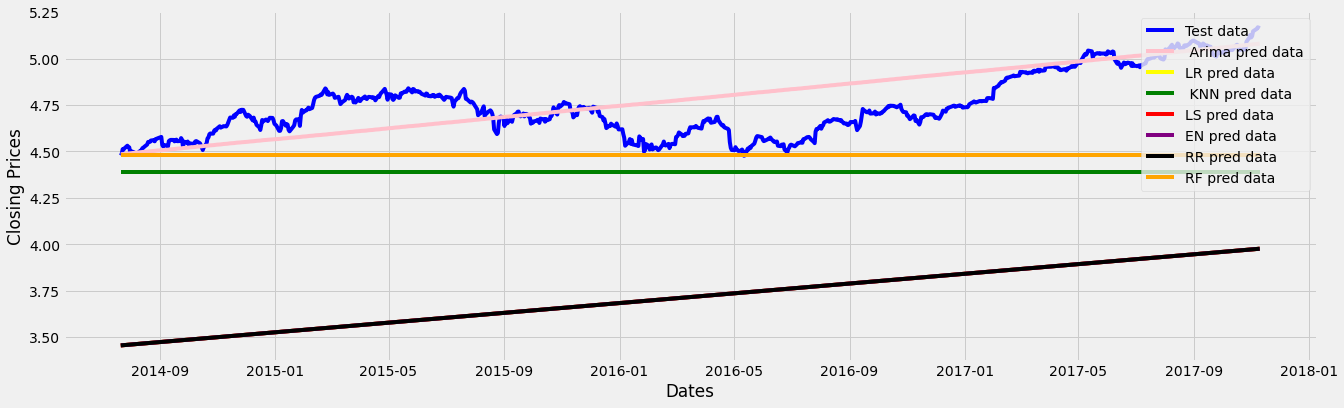

In [82]:
getAverages([apple])